In [1]:
import warnings

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import (
    Input, Lambda, Embedding, GRU, Bidirectional, Concatenate, Dense
)
from tensorflow.keras.regularizers import L1L2
import numpy as np
import pandas as pd

import nltk
import gensim.downloader
import re
from calendar import day_name, day_abbr, month_name, month_abbr
from collections import Counter

from sklearn import preprocessing
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef, confusion_matrix
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

In [2]:
# constants that will be used as tokens
PAD = '~PAD~'
URL = '~URL~'
DATETIME = '~DATETIME~'
QUANTITY = '~QUANTITY~'
NUM = '~NUM~'
UNK = '~UNK~'

# regexes to be applied prior to tokenization
url_regex = '(www\.|http://|https://)\S+|\S+\.(co|org|net|info|be|gov|edu|html|jpg|jpeg|png|gif)'
date_regex = '('        + '|'.join(day_name[i] for i in range(7)) +\
             '|'        + '|'.join(day_abbr[i] for i in range(7)) +\
             ')?,?\s?(' + '|'.join(month_name[i] for i in range(1, 13)) +\
             '|'        + '|'.join(month_abbr[i] for i in range(1, 13)) +\
             ")\s\d{1,2}(st|nd|rd|th)?(,?\s'?\d{2,4})?"
time_regex = '((\d+\:\d+)(\s?[AaPp]\.\s?[Mm]\.)?)|((\d+\:\d+\s?)?([AaPp]\.\s?[Mm]\.))'
quantity_regex = '\d+((\,?\d+)+)?'

# list of stopwords
stopwords = nltk.corpus.stopwords.words('english')

In [3]:
### HYPERPARAMETERS ###
PERCENT_TEST = 0.075
PERCENT_VAL  = 0.075
val_split = PERCENT_VAL / (1 - PERCENT_TEST)
TOKENIZE_FN = nltk.word_tokenize
MAX_TEXT_LEN = 512
MAX_TITLE_LEN = 64
TEXT_UNITS = 128
TITLE_UNITS = 64
BATCH_SIZE = 64
EPOCHS = 5
LEARNING_RATE = 2e-5
L1_REGULARIZER = 1e-6
L2_REGULARIZER = 2e-6
DROPOUT = 0.2
OPTIMIZER = tf.keras.optimizers.Adam
optimizer = OPTIMIZER(learning_rate=LEARNING_RATE)

### RANDOM SEED (for reproducibility) ###
SEED = 42
np.random.seed(SEED)
seed = SEED

In [4]:
%%time

# download our pretrained word embedding with embedding size of 300
EMBED_SIZE = 300
gn300_raw = gensim.downloader.load('word2vec-google-news-300')
gn300 = gn300_raw

# """
# Condense our pretrained word embedding using the following two techniques:
# 1) remove stopwords
# 2) make all keys lowercase, group by key, and take average per key.
# E.g. (gn300_raw['beyonce'] +
#       gn300_raw['Beyonce'] +
#       gn300_raw['BEYONCE']) / 3 -> gn300['beyonce']
# """
# S = Counter() # vector sum
# C = Counter() # vector count
# for word in gn300_raw.vocab:
#     lower = word.lower()
#     if lower in stopwords: continue
#     S[lower] += gn300_raw[word]
#     C[lower] += 1
# # create condensed word2vec (just a simple dictionary)
# gn300 = {w: s / c for w, s, c in zip(S.keys(), S.values(), C.values())}

CPU times: user 36.1 s, sys: 1.57 s, total: 37.7 s
Wall time: 39.1 s


In [5]:
def strip_all_duplicates(df):
    r = pd.DataFrame()
    for column in ['title', 'text']:
        c = df[column]
        flag = c.isin(c[c.duplicated()])
        r = pd.concat([r, df.loc[flag]])
    r = r.drop_duplicates()
    return df[~df.index.isin(r.index)], r

def get_real_fake(df):
    real = df[df.label.isin([0, 'REAL'])]
    fake = df[df.label.isin([1, 'FAKE'])]
    return real, fake

def split_df(df):
    global seed
    train, test = train_test_split(df, test_size=PERCENT_TEST, random_state=seed)
    seed += 1
    tr, val = train_test_split(train, test_size=val_split, random_state=seed)
    seed += 1
    return tr, val, test

def concat_and_shuffle(dfs):
    global seed
    df = pd.concat(dfs)
    df = df.sample(frac=1, random_state=seed)
    seed += 1
    return df

In [6]:
# get data
df = pd.read_csv('news.csv')
df = df.drop(columns=['Unnamed: 0'])
df = df.drop_duplicates()
print(len(df), len(pd.read_csv('news.csv')) - len(df))
df, _ = strip_all_duplicates(df)
df

6306 29


,title,text,label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
...,...,...,...
6330,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL
6331,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE
6332,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,FAKE
6333,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL


In [7]:
real, fake = get_real_fake(df)

real_tr, real_val, real_test = split_df(real)
fake_tr, fake_val, fake_test = split_df(fake)

# def split_by_author(df):
#     # take counts grouped by author
#     author = df.author.value_counts()
#     # split authors into groups
#     author_tr, author_val, author_test = split_df(author)
#     # split data by author group
#     tr = df[df.author.isin(author_tr.index)].copy(deep=True)
#     val = df[df.author.isin(author_val.index)].copy(deep=True)
#     test = df[df.author.isin(author_test.index)].copy(deep=True)
#     return tr, val, test

# real_tr, real_val, real_test = split_by_author(real)
# fake_tr, fake_val, fake_test = split_by_author(fake)

# real_author_counts = real.author.value_counts()
# fake_author_counts = fake.author.value_counts()
# mixed_authors = real_author_counts.index.intersection(fake_author_counts.index)
# real_author_counts[mixed_authors], fake_author_counts[mixed_authors]

In [8]:
train = pd.concat([concat_and_shuffle([real_tr, fake_tr]),
                   concat_and_shuffle([real_val, fake_val])])
test = concat_and_shuffle([real_test, fake_test])

# Expected result of val_split. This is just to give us a
# sense of the distribution of labels.
def display_count(df):
    print(len(df[df.label.isin([0, 'REAL'])]),
          len(df[df.label.isin([1, 'FAKE'])]))
display_count(train.iloc[:-int(val_split * len(train))])
display_count(train.iloc[-int(val_split * len(train)):])
display_count(test)

2517 2517
221 223
222 223


In [9]:
# def supertokenize(text):
#     # e.g. split_by_case('ILoveNewYork') == ['I', 'Love', 'New', 'York']
#     def split_by_case(s):
#         if (not s[1:].isupper()) and (not s[1:].islower()):
#             for i in range(1, len(s) - 1):
#                 if s[i].isupper():
#                     return [s[:i]] + split_by_case(s[i:])
#                 elif s[i + 1].isupper():
#                     return [s[:i + 1]] + split_by_case(s[i + 1:])
#         return [s]
#     text = re.sub(quantity_regex, QUANTITY, 
#                  re.sub(time_regex, DATETIME, 
#                         re.sub(date_regex, DATETIME, 
#                                re.sub(url_regex, URL, text))))
#     text = text.replace('•', '')
#     raw_tokens = nltk.word_tokenize(text)
#     tokens = []
#     for t in raw_tokens:
#         if t in '!"\'(),--./:;<?[\\]{|}“”‘’—': continue
#         if t.lower() != "n't": t = re.sub('[\"\']', '', t)
#         if (len(t) > 2) and (t.lower() == t) and (t[-1] == '.'): t = t[:-1]
#         if t == URL:
#             tokens.append(URL)
#             continue
#         if (t == DATETIME) or (re.sub('^\d+(/\d+)+$', '', t) == ''):
#             tokens.append(DATETIME)
#             continue
#         if t == QUANTITY:
#             tokens.append(QUANTITY)
#             continue
#         if t.isnumeric() or (t[:-2].isnumeric() and (t[-2:] in ['st', 'nd', 'rd', 'th'])):
#             tokens.append(NUM)
#             continue
#         t = t.lower()
#         if t in stopwords: continue
#         if t in gn300:
#             tokens.append(t)
#         else:
#             if t + '.' in gn300:
#                 tokens.append(t + '.')
#                 continue
#             if t.replace('.', '') in gn300:
#                 tokens.append(t.replace('.', ''))
#                 continue
#             is_found = False
#             for x in split_by_case(re.sub('[^a-z]', '', t)):
#                 if x in gn300:
#                     tokens.append(x)
#                     is_found = True
#             if is_found: continue
#             for st in re.split('-', re.sub('[^a-z0-9\.~]', '-', t)):
#                 for x in [st, st[:-1], st[1:], st.replace('s', 'z'), 
#                           st.replace('ou', 'o'), st.replace('re', 'er')]:
#                     if x in gn300:
#                         tokens.append(x)
#                         is_found = True
#                         break
#             if not is_found: tokens.append(UNK)
#     return tokens

In [10]:
# this does tokenization as well as tracking token counts grouped by label
def tokenize_and_update_word_counts(text, label, tokenize_fn):
    global tc_real, tc_fake
    tokens = tokenize_fn(text)
    tc = Counter(tokens)
    if label in [0, 'REAL']:
        tc_fake += tc
    elif label in [1, 'FAKE']:
        tc_real += tc
    else:
        warnings.warn('Unexpected label %s'.format(label))
    return tokens

In [11]:
%%time

tc_real = Counter()
tc_fake = Counter()

train['tokenized_title'] = train.apply(lambda x, y: tokenize_and_update_word_counts(
    x.title, x.label, y), axis=1, args=(TOKENIZE_FN,))
train['tokenized_text'] = train.apply(lambda x, y: tokenize_and_update_word_counts(
    x.text, x.label, y), axis=1, args=(TOKENIZE_FN,))

T = Counter()
for k in tc_real + tc_fake:
    T[k] = abs(tc_real[k] - tc_fake[k]) / np.sqrt(tc_real[k] + tc_fake[k])

thresh = T.most_common(25000)[-1][1]
tokens = [k for k, v in T.items() if v >= thresh]

vocab, i = {PAD: 0, URL: 1, DATETIME: 2, QUANTITY: 3, NUM: 4, UNK: 5}, 6
for w in tokens:
    if w in (PAD, URL, DATETIME, QUANTITY, NUM, UNK): continue
    vocab[w] = i
    i += 1
id2word = {v: k for k, v in vocab.items()}

i, T.most_common(10)

CPU times: user 55.4 s, sys: 152 ms, total: 55.5 s
Wall time: 55.5 s


(25165,
 [("''", 102.84380734536683),
  ('``', 101.27633147686663),
  ("'s", 100.89614442830332),
  ('said', 88.94252769319633),
  ('.', 83.79805470924654),
  (',', 82.3310129155866),
  ('he', 75.12431745455352),
  ('a', 72.0663211435427),
  ('the', 64.27344646852316),
  ('his', 63.027412424921366)])

In [12]:
%%time
test['tokenized_title'] = test.apply(lambda x: TOKENIZE_FN(x.title), axis=1)
test['tokenized_text'] = test.apply(lambda x: TOKENIZE_FN(x.text), axis=1)

CPU times: user 2.55 s, sys: 16 ms, total: 2.57 s
Wall time: 2.57 s


In [13]:
def clean(text,length):
    f = [vocab[w] if w in vocab else vocab[UNK] for w in text]
    f = f[:length]
    return (length - len(f)) * [vocab[PAD]] + f
train['text_as_ints'] = train.tokenized_text.apply(clean, args=[MAX_TEXT_LEN])
train['title_as_ints'] = train.tokenized_text.apply(clean, args=[MAX_TITLE_LEN])
test['text_as_ints'] = test.tokenized_text.apply(clean, args=[MAX_TEXT_LEN])
test['title_as_ints'] = test.tokenized_text.apply(clean, args=[MAX_TITLE_LEN])

In [14]:
X_train = [np.array(train.text_as_ints.to_list()), np.array(train.title_as_ints.to_list())]
X_test = [np.array(test.text_as_ints.to_list()), np.array(test.title_as_ints.to_list())]

# binarize labels
lb = preprocessing.LabelBinarizer()
y_train = lb.fit_transform(train.label)
y_test = lb.fit_transform(test.label)

# compute class weights based on training labels
class_weights = class_weight.compute_class_weight('balanced', classes=[0, 1],
                                                  y=[w for x in y_train for w in x])
class_weights = {i: weight for i, weight in enumerate(class_weights)}

In [15]:
input_text = Input(shape=[None])
input_title = Input(shape=[None])
mask = Lambda(lambda inputs: K.not_equal(inputs, 0))
def generate_embedding():
    emb = np.zeros((len(vocab), EMBED_SIZE))
#     v = np.random.uniform(-1, 1, EMBED_SIZE)
    for i in range(len(vocab)):
        try:
            g = gn300[id2word[i]]
            emb[i] = g #+ v * np.linalg.norm(g) / np.linalg.norm(v)
        except KeyError:
            pass
#             assert i <= 5, i
#             if i in [1, 2, 3, 4]: # leave PAD and UNK zero
#                 e[i] = v / np.linalg.norm(v)
    return Embedding(input_dim=emb.shape[0],
                     output_dim=emb.shape[1],
                     weights=[emb],
#                      trainable=False
                    )
emb_text = generate_embedding()(input_text)
emb_title = generate_embedding()(input_title)
gru = lambda units: GRU(units, dropout=DROPOUT, recurrent_dropout=DROPOUT,
                        kernel_regularizer=L1L2(l1=L1_REGULARIZER,
                                                l2=L2_REGULARIZER))
gru_text = Bidirectional(gru(TEXT_UNITS))(emb_text, mask=mask(input_text))
gru_title = gru(TITLE_UNITS)(emb_title, mask=mask(input_title))
concat = Concatenate()([gru_text, gru_title])
outputs = Dense(1, activation='sigmoid')(concat)
model = tf.keras.Model(inputs=[input_text, input_title], outputs=[outputs])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 300)    7549500     input_1[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, None)         0           input_1[0][0]                    
                                                                 input_2[0][0]                

In [16]:
# model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics='accuracy')
# model.fit(X_train, y_train, batch_size=BATCH_SIZE, class_weight=class_weights)

In [17]:
# for i in range(len(model.layers)):
#     model.layers[i].trainable = False
#     if i in [2, 4]:
#         model.layers[i].trainable = True
# model.summary()

In [18]:
# model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics='accuracy')
# model.fit(X_train, y_train, batch_size=BATCH_SIZE, class_weight=class_weights)

In [19]:
# for i in range(len(model.layers)):
#     model.layers[i].trainable = True
# model.summary()

In [20]:
from sklearn.utils import class_weight
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics='accuracy')
checkpoint_filepath = '/tmp/checkpoint_v0'
model.fit(
    X_train, y_train, batch_size=BATCH_SIZE, class_weight=class_weights,
    validation_split=val_split, epochs=EPOCHS,
    callbacks=[tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True
    )]
)

Epoch 1/5
79/79 [==============================] - 171s 2s/step - loss: 0.7019 - accuracy: 0.5653 - val_loss: 0.6785 - val_accuracy: 0.7258
Epoch 2/5
79/79 [==============================] - 167s 2s/step - loss: 0.6733 - accuracy: 0.7252 - val_loss: 0.6524 - val_accuracy: 0.7708
Epoch 3/5
79/79 [==============================] - 167s 2s/step - loss: 0.6438 - accuracy: 0.7834 - val_loss: 0.6259 - val_accuracy: 0.7933
Epoch 4/5
79/79 [==============================] - 48352s 620s/step - loss: 0.6149 - accuracy: 0.8051 - val_loss: 0.5965 - val_accuracy: 0.8067
Epoch 5/5
79/79 [==============================] - 163s 2s/step - loss: 0.5838 - accuracy: 0.8247 - val_loss: 0.5614 - val_accuracy: 0.8270


In [21]:
model.load_weights(checkpoint_filepath)
logits = model.predict(X_test)
most_off = np.argmax(np.abs(y_test - logits))
print(y_test[most_off], logits[most_off])
test.iloc[most_off].title, test.iloc[most_off].text

[0] [0.6457656]


('Donald Trump kicks off final campaign day with Fla. rally',
 'Donald Trump kicks off final campaign day with Fla. rally 11/07/2016 \nBOSTON GLOBE \n\nDonald Trump is criticizing the FBI’s decision not to criminally charge Hillary Clinton. He says ‘‘now it’s up to the American people to deliver justice at the ballot box.’’ \nTrump kicked off his Election Day eve blitz with a rally Monday in Florida. He told the Sarasota crowd that ‘‘the system is rigged, but at least we know it.’’ \nHe claimed that ‘‘our country is a laughing stock all over the world.’’ \nThe Republican nominee than pantomimed quotation marks when he said the word ‘‘justice’’ as he hit the FBI and the Department of Justice for their handling of the case. \nFBI Director James Comey notified Congress Sunday that a review of new emails connected to Clinton’s servers did produce evidence that would warrant charges. \n11:45 a.m. \nAn ex-aide to former President Bill Clinton alleged in a hacked email that Chelsea Clinton us

In [22]:
y_pred = np.round(logits)
print(matthews_corrcoef(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
model.evaluate(X_test, y_test)

0.7088496922944525
[[171  52]
 [ 15 207]]
14/14 [==============================] - 2s 154ms/step - loss: 0.5589 - accuracy: 0.8494


[0.5588874220848083, 0.8494381904602051]

In [23]:
def get_reshaped_weights(model,layer_id):
    W=np.array(model.layers[layer_id].get_weights())
    W=W.reshape(W.shape[1],W.shape[2])
    return W
text_embed = get_reshaped_weights(model,2)
title_embed = get_reshaped_weights(model,4)

<ipython-input-24-f95f7377f377>:8: RuntimeWarning: divide by zero encountered in true_divide
  cs = W.dot(b) / (np.linalg.norm(W, axis=1) * np.linalg.norm(b))
<ipython-input-24-f95f7377f377>:8: RuntimeWarning: invalid value encountered in true_divide
  cs = W.dot(b) / (np.linalg.norm(W, axis=1) * np.linalg.norm(b))
<ipython-input-24-f95f7377f377>:4: RuntimeWarning: invalid value encountered in greater_equal
  n_ = np.sum(arr >= thresh)
/home/christophercoffee/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 146 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/christophercoffee/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/christophercoffee/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 153 missing from current font.
  font.set_text(s, 0.

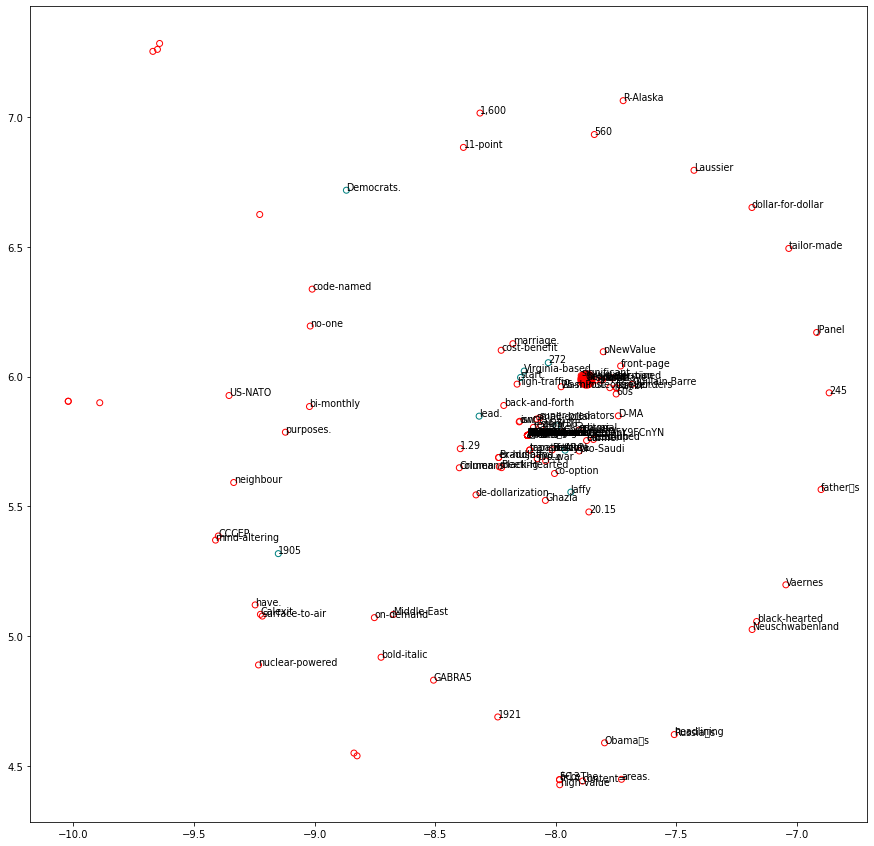

In [24]:
def get_top_n_plus_ties(arr, n):
    sorted_args = np.argsort(-arr)
    thresh = arr[sorted_args[n]]
    n_ = np.sum(arr >= thresh)
    return sorted_args[:n_]
def get_most_similar(word, W, n):
    b = W[vocab[word]]
    cs = W.dot(b) / (np.linalg.norm(W, axis=1) * np.linalg.norm(b))
    return get_top_n_plus_ties(cs, n)
def create_words_plot(embed1, embed2, WORD, k=9):
    ids1 = get_most_similar(WORD, embed1, k-1)
    ids2 = get_most_similar(WORD, embed2, k-1)
    words1 = [id2word[i] for i in ids1]
    words2 = [id2word[i] for i in ids2]
    v = TSNE(n_components=2,random_state=SEED).fit_transform(
        np.concatenate([embed1[ids1],embed2[ids2]]))
    fig = plt.figure(figsize=(15,15))
    plt.scatter(v[:k,0],v[:k,1],facecolors='none',edgecolors='teal')
    plt.scatter(v[k:,0],v[k:,1],facecolors='none',edgecolors='red')
    for i, word in enumerate(words1):
        plt.annotate(word,(v[i,0],v[i,1]),size=9.5)
        if word == WORD:
            plt.scatter(v[i,0],v[i,1],c='teal',s=300)
    for i, word in enumerate(words2):
        plt.annotate(word,(v[i+k,0],v[i+k,1]),size=9.5)
        if word == WORD:
            plt.scatter(v[i+k,0],v[i+k,1],c='red',s=300)
create_words_plot(text_embed,title_embed,'headline')